In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model#type:ignore
from tensorflow.keras.layers import (#type:ignore
    Input, Conv3D, Conv2D, Reshape, MaxPooling3D, MaxPooling2D,
    Flatten, Dense, Dropout, BatchNormalization
) 
from tensorflow.keras.optimizers import Adam#type:ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint#type:ignore
from tensorflow.keras.utils import to_categorical#type:ignore
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)

2025-09-13 01:35:25.964790: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-13 01:35:25.972881: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-13 01:35:26.243022: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-13 01:35:27.466175: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [4]:
X_train = np.load('../data/processed/X_train_pca.npy')
X_val = np.load('../data/processed/X_val_pca.npy')
X_test = np.load('../data/processed/X_test_pca.npy')
y_train = np.load('../data/processed/y_train.npy')
y_val = np.load('../data/processed/y_val.npy')
y_test = np.load('../data/processed/y_test.npy')
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")

Training data shape: (6149, 25, 25, 30, 1)
Validation data shape: (2050, 25, 25, 30, 1)
Test data shape: (2050, 25, 25, 30, 1)
Training labels shape: (6149,)


In [3]:
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1
print("Adjusted unique values in y_train:", np.unique(y_train))
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("\nClass weights:")
for cls, weight in class_weights.items():
    print(f"Class {cls}: {weight:.2f}")

Adjusted unique values in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

Class weights:
Class 0: 13.73
Class 1: 0.45
Class 2: 0.77
Class 3: 2.69
Class 4: 1.33
Class 5: 0.88
Class 6: 22.61
Class 7: 1.34
Class 8: 32.03
Class 9: 0.66
Class 10: 0.26
Class 11: 1.08
Class 12: 3.12
Class 13: 0.51
Class 14: 1.66
Class 15: 6.86


In [4]:
def create_hybridsn_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    x = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    shape = x.shape
    x = Reshape((shape[1], shape[2], shape[3] * shape[4]))(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
num_classes = len(np.unique(y_train))
model = create_hybridsn_model(input_shape, num_classes)

model.summary()

E0000 00:00:1757592179.070413    7968 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1757592179.077182    7968 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25, 25, 30, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 25, 25, 30, 8)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 25, 30, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 25, 25, 30, 16) │         5,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 30, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 25, 480)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 25, 25, 32)     │       138,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,240,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,438,752 (39.82 MB)

 Trainable params: 10,438,512 (39.82 MB)

 Non-trainable params: 240 (960.00 B)

In [5]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau#type:ignore
os.makedirs('../models', exist_ok=True)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath='../models/hybridsn_baseline_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [9]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.3011 - loss: 5.7741
Epoch 1: val_accuracy improved from None to 0.54732, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0.3711 - loss: 5.5212 - val_accuracy: 0.5473 - val_loss: 1.9226 - learning_rate: 0.0010
Epoch 2/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5621 - loss: 1.8341
Epoch 2: val_accuracy improved from 0.54732 to 0.67707, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.6001 - loss: 1.8454 - val_accuracy: 0.6771 - val_loss: 4.0754 - learning_rate: 0.0010
Epoch 3/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5843 - loss: 2.6442
Epoch 3: val_accuracy did not improve from 0.67707
193/193 ━━━━━━━━━━━━━━━━━━━━ 50s 259ms/step - accuracy: 0.5456 - loss: 3.0021 - val_accuracy: 0.6322 - val_loss: 1.6791 - learning_rate: 0.0010
Epoch 4/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5459 - loss: 2.0582
Epoch 4: val_accuracy improved from 0.67707 to 0.80927, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 254ms/step - accuracy: 0.5819 - loss: 1.9813 - val_accuracy: 0.8093 - val_loss: 0.6386 - learning_rate: 0.0010
Epoch 5/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.6790 - loss: 1.4419
Epoch 5: val_accuracy did not improve from 0.80927
193/193 ━━━━━━━━━━━━━━━━━━━━ 50s 259ms/step - accuracy: 0.6756 - loss: 1.3754 - val_accuracy: 0.7980 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 6/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7120 - loss: 0.9602
Epoch 6: val_accuracy improved from 0.80927 to 0.88195, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 255ms/step - accuracy: 0.7333 - loss: 0.9682 - val_accuracy: 0.8820 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 7/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.7539 - loss: 1.1277
Epoch 7: val_accuracy did not improve from 0.88195
193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 256ms/step - accuracy: 0.7383 - loss: 1.1577 - val_accuracy: 0.8483 - val_loss: 0.6275 - learning_rate: 0.0010
Epoch 8/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7250 - loss: 0.8663
Epoch 8: val_accuracy did not improve from 0.88195
193/193 ━━━━━━━━━━━━━━━━━━━━ 50s 258ms/step - accuracy: 0.7596 - loss: 0.7861 - val_accuracy: 0.7985 - val_loss: 0.7259 - learning_rate: 0.0010
Epoch 9/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.7775 - loss: 0.8221
Epoch 9: val_accuracy improved from 0.88195 to 0.91122, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 51s 263ms/step - accuracy: 0.7700 - loss: 0.8535 - val_accuracy: 0.9112 - val_loss: 0.3045 - learning_rate: 0.0010
Epoch 10/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8146 - loss: 0.5177
Epoch 10: val_accuracy improved from 0.91122 to 0.94244, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 53s 274ms/step - accuracy: 0.8377 - loss: 0.4534 - val_accuracy: 0.9424 - val_loss: 0.2133 - learning_rate: 0.0010
Epoch 11/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8394 - loss: 0.6330
Epoch 11: val_accuracy improved from 0.94244 to 0.95073, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 51s 266ms/step - accuracy: 0.8362 - loss: 0.6045 - val_accuracy: 0.9507 - val_loss: 0.1598 - learning_rate: 0.0010
Epoch 12/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8833 - loss: 0.4219
Epoch 12: val_accuracy did not improve from 0.95073
193/193 ━━━━━━━━━━━━━━━━━━━━ 53s 273ms/step - accuracy: 0.8743 - loss: 0.5388 - val_accuracy: 0.9468 - val_loss: 0.1731 - learning_rate: 0.0010
Epoch 13/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8511 - loss: 0.4873
Epoch 13: val_accuracy did not improve from 0.95073
193/193 ━━━━━━━━━━━━━━━━━━━━ 51s 264ms/step - accuracy: 0.8626 - loss: 0.4004 - val_accuracy: 0.9478 - val_loss: 0.1658 - learning_rate: 0.0010
Epoch 14/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8816 - loss: 0.5963
Epoch 14: val_accuracy improved from 0.95073 to 0.95366, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 51s 263ms/step - accuracy: 0.8759 - loss: 0.4805 - val_accuracy: 0.9537 - val_loss: 0.1834 - learning_rate: 0.0010
Epoch 15/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8293 - loss: 2.1934
Epoch 15: val_accuracy did not improve from 0.95366
193/193 ━━━━━━━━━━━━━━━━━━━━ 51s 266ms/step - accuracy: 0.8153 - loss: 1.3695 - val_accuracy: 0.8937 - val_loss: 0.3347 - learning_rate: 0.0010
Epoch 16/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8493 - loss: 0.5469
Epoch 16: val_accuracy did not improve from 0.95366

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
193/193 ━━━━━━━━━━━━━━━━━━━━ 51s 264ms/step - accuracy: 0.8632 - loss: 0.5331 - val_accuracy: 0.9410 - val_loss: 0.1854 - learning_rate: 0.0010
Epoch 17/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8811 - loss: 0.3133
Epoch 17: val_accuracy improved from 0.95366 to 0.98585, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 51s 262ms/step - accuracy: 0.8938 - loss: 0.2532 - val_accuracy: 0.9859 - val_loss: 0.0741 - learning_rate: 5.0000e-04
Epoch 18/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9036 - loss: 0.2215
Epoch 18: val_accuracy improved from 0.98585 to 0.99073, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 51s 262ms/step - accuracy: 0.9161 - loss: 0.1845 - val_accuracy: 0.9907 - val_loss: 0.0594 - learning_rate: 5.0000e-04
Epoch 19/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9369 - loss: 0.1572
Epoch 19: val_accuracy improved from 0.99073 to 0.99366, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 50s 261ms/step - accuracy: 0.9405 - loss: 0.1424 - val_accuracy: 0.9937 - val_loss: 0.0426 - learning_rate: 5.0000e-04
Epoch 20/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9404 - loss: 0.2148
Epoch 20: val_accuracy did not improve from 0.99366
193/193 ━━━━━━━━━━━━━━━━━━━━ 50s 259ms/step - accuracy: 0.9455 - loss: 0.1567 - val_accuracy: 0.9927 - val_loss: 0.0441 - learning_rate: 5.0000e-04
Epoch 21/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9445 - loss: 0.1550
Epoch 21: val_accuracy did not improve from 0.99366
193/193 ━━━━━━━━━━━━━━━━━━━━ 50s 258ms/step - accuracy: 0.9468 - loss: 0.1454 - val_accuracy: 0.9907 - val_loss: 0.0999 - learning_rate: 5.0000e-04
Epoch 22/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9457 - loss: 0.1547
Epoch 22: val_accuracy did not improve from 0.99366
193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 256ms/step - accuracy: 0.9532 - loss: 0.1169 - val_accuracy: 0.9937 - val_loss: 0.0364 - learning

193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.9605 - loss: 0.1336 - val_accuracy: 0.9961 - val_loss: 0.0380 - learning_rate: 5.0000e-04
Epoch 24/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9581 - loss: 0.1580
Epoch 24: val_accuracy did not improve from 0.99610
193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.9510 - loss: 0.2475 - val_accuracy: 0.9829 - val_loss: 0.1078 - learning_rate: 5.0000e-04
Epoch 25/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9258 - loss: 0.3889
Epoch 25: val_accuracy did not improve from 0.99610
193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 256ms/step - accuracy: 0.9405 - loss: 0.3255 - val_accuracy: 0.9902 - val_loss: 0.0412 - learning_rate: 5.0000e-04
Epoch 26/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9476 - loss: 0.2132
Epoch 26: val_accuracy did not improve from 0.99610
193/193 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.9445 - loss: 0.2190 - val_accuracy: 0.9932 - val_loss: 0.0348 - learning

193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.9854 - loss: 0.0706 - val_accuracy: 0.9966 - val_loss: 0.0120 - learning_rate: 2.5000e-04
Epoch 39/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9879 - loss: 0.0257
Epoch 39: val_accuracy improved from 0.99659 to 0.99756, saving model to ../models/hybridsn_baseline_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 48s 250ms/step - accuracy: 0.9891 - loss: 0.0213 - val_accuracy: 0.9976 - val_loss: 0.0185 - learning_rate: 2.5000e-04
Epoch 40/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9888 - loss: 0.0214
Epoch 40: val_accuracy did not improve from 0.99756
193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 256ms/step - accuracy: 0.9902 - loss: 0.0362 - val_accuracy: 0.9922 - val_loss: 0.0269 - learning_rate: 2.5000e-04
Epoch 41/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9841 - loss: 0.0288
Epoch 41: val_accuracy did not improve from 0.99756
193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.9857 - loss: 0.0341 - val_accuracy: 0.9961 - val_loss: 0.0268 - learning_rate: 2.5000e-04
Epoch 42/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9855 - loss: 0.0541
Epoch 42: val_accuracy did not improve from 0.99756
193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.9862 - loss: 0.0527 - val_accuracy: 0.9971 - val_loss: 0.0352 - learning

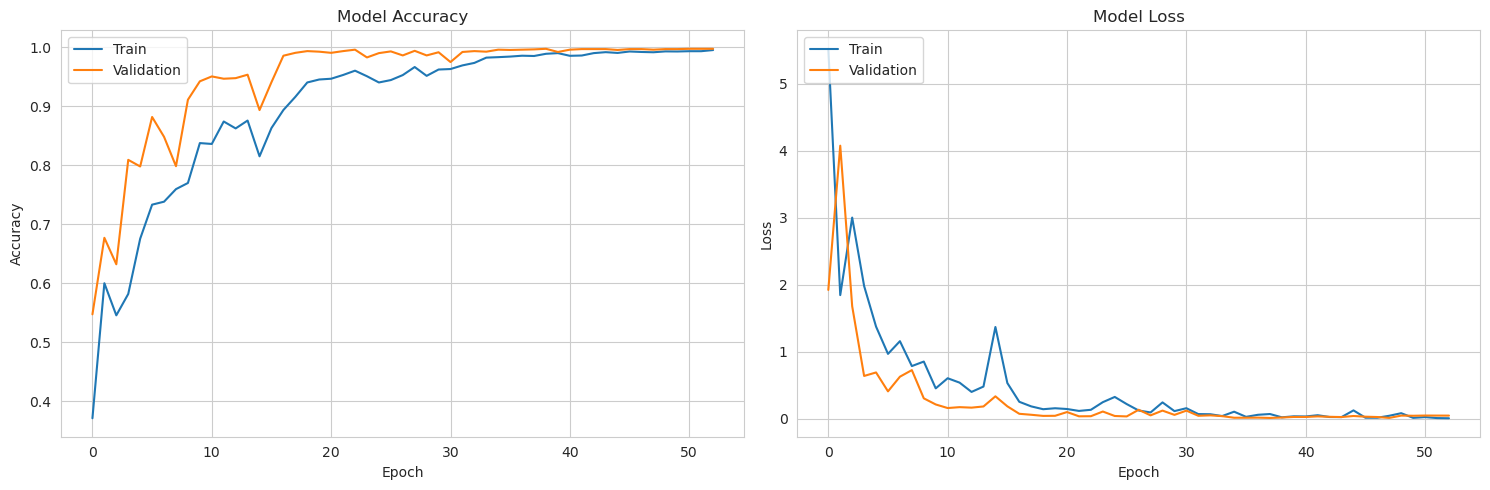

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
model.load_weights('../models/hybridsn_baseline_best.h5')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

Test Accuracy: 0.9976
Test Loss: 0.0071
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       286
           2       1.00      1.00      1.00       166
           3       1.00      1.00      1.00        47
           4       1.00      1.00      1.00        97
           5       0.99      1.00      1.00       146
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00        96
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00       194
          10       1.00      1.00      1.00       491
          11       1.00      0.98      0.99       119
          12       1.00      1.00      1.00        41
          13       1.00      0.99      1.00       253
          14       0.97      1.00      0.99        77
          15       0.90      1.00      0.95        19

    accuracy                           1.00      2050
   

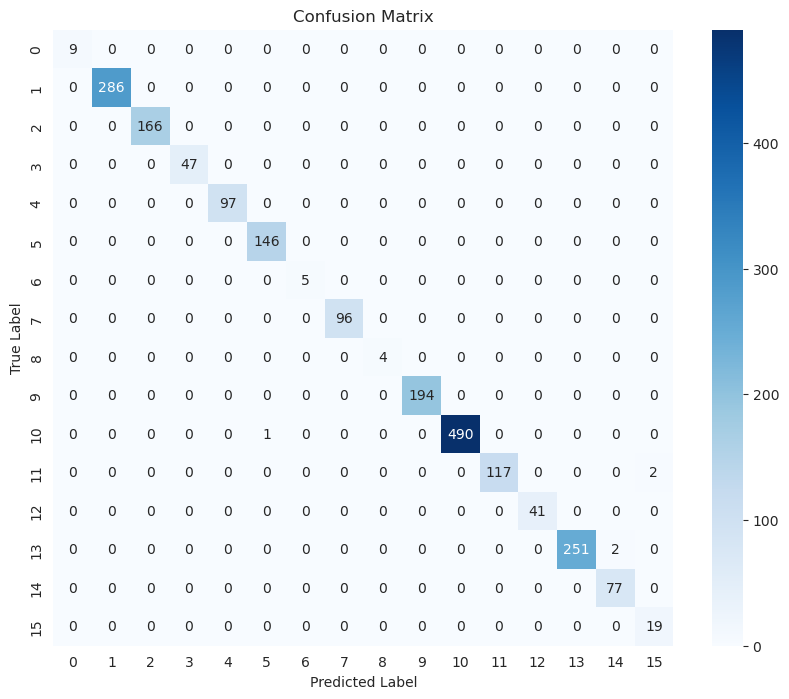

In [13]:
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"Weighted F1-Score: {f1:.4f}")
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [14]:
model.save('../models/hybridsn_baseline_final.h5')
print("Model saved successfully!")

Model saved successfully!


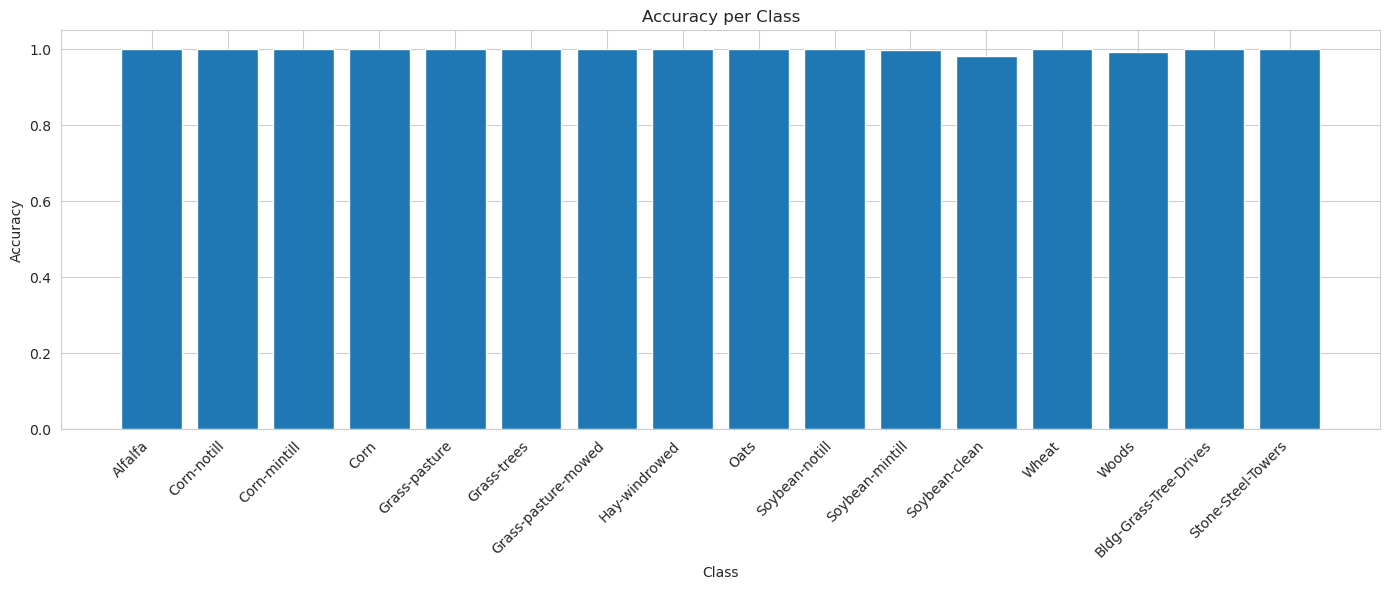


Class-wise Accuracy:
Alfalfa: 1.0000
Corn-notill: 1.0000
Corn-mintill: 1.0000
Corn: 1.0000
Grass-pasture: 1.0000
Grass-trees: 1.0000
Grass-pasture-mowed: 1.0000
Hay-windrowed: 1.0000
Oats: 1.0000
Soybean-notill: 1.0000
Soybean-mintill: 0.9980
Soybean-clean: 0.9832
Wheat: 1.0000
Woods: 0.9921
Bldg-Grass-Tree-Drives: 1.0000
Stone-Steel-Towers: 1.0000


In [15]:
class_names = [
    'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 
    'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 
    'Soybean-clean', 'Wheat', 'Woods', 'Bldg-Grass-Tree-Drives', 'Stone-Steel-Towers'
]
class_accuracy = {}
for i in range(num_classes):
    mask = y_test == i
    if np.sum(mask) > 0: 
        class_accuracy[class_names[i]] = np.sum(y_pred_classes[mask] == i) / np.sum(mask)

plt.figure(figsize=(14, 6))
plt.bar(range(len(class_accuracy)), list(class_accuracy.values()))
plt.title('Accuracy per Class')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(range(len(class_accuracy)), list(class_accuracy.keys()), rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nClass-wise Accuracy:")
for cls, acc in class_accuracy.items():
    print(f"{cls}: {acc:.4f}")

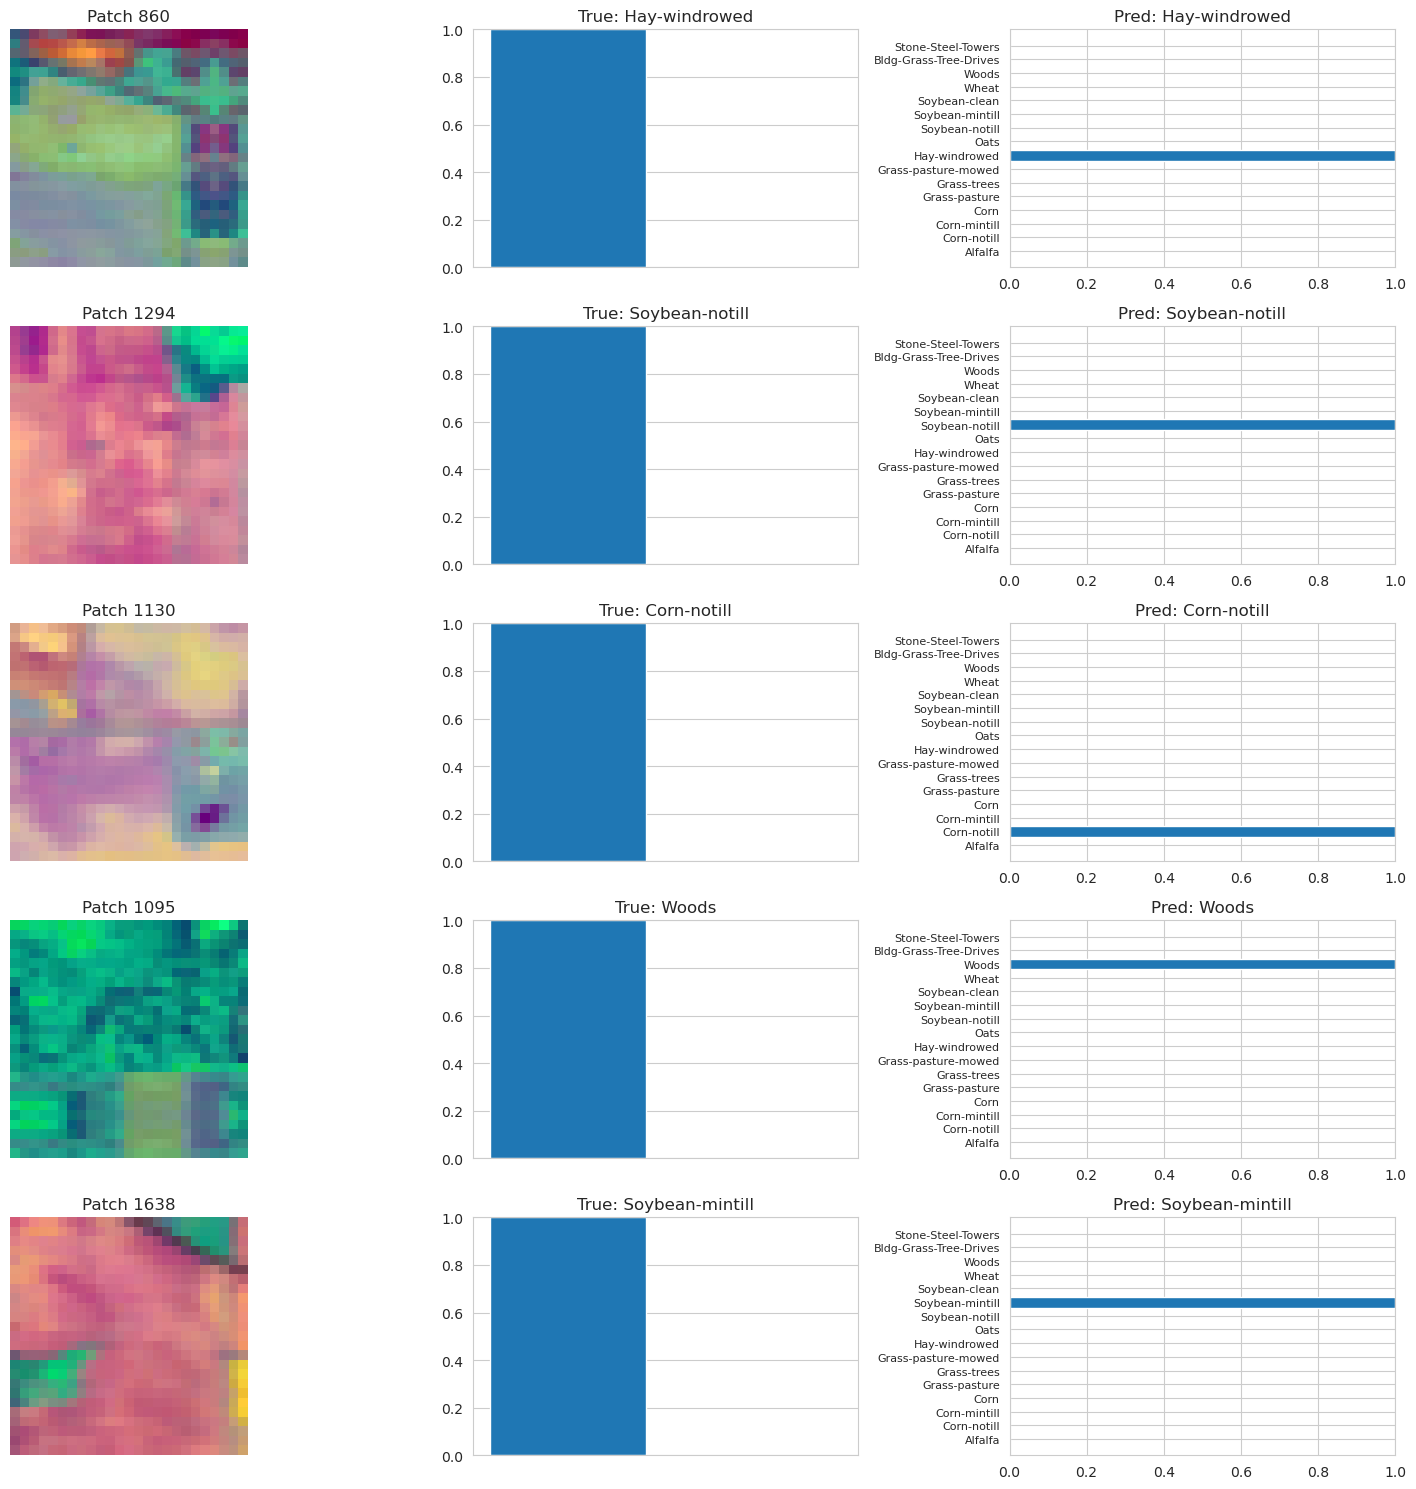

In [16]:
def visualize_predictions(X, y_true, y_pred, class_names, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*3))
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        
        rgb_patch = X[idx, :, :, :3, 0]  
        rgb_patch = (rgb_patch - rgb_patch.min()) / (rgb_patch.max() - rgb_patch.min())
        
        axes[i, 0].imshow(rgb_patch)
        axes[i, 0].set_title(f'Patch {idx}')
        axes[i, 0].axis('off')
        
        axes[i, 1].bar([0, 1], [1, 0])
        axes[i, 1].set_title(f'True: {class_names[y_true[idx]]}')
        axes[i, 1].set_ylim(0, 1)
        axes[i, 1].set_xticks([])

        axes[i, 2].barh(range(len(y_pred[idx])), y_pred[idx])
        axes[i, 2].set_title(f'Pred: {class_names[y_pred_classes[idx]]}')
        axes[i, 2].set_xlim(0, 1)
        axes[i, 2].set_yticks(range(len(class_names)))
        axes[i, 2].set_yticklabels(class_names, fontsize=8)
    
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, y_pred, class_names)